In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.color import rgb2hed

In [2]:
BASE_DIR = 'D:/MSC/Data Mining/CW2/DATA/'

In [3]:
X = np.load(BASE_DIR + "images.npy")#read images
Y = pd.read_csv(BASE_DIR + 'counts.csv')#read cell counts
F = np.loadtxt(BASE_DIR + 'split.txt')#read fold information

## Question 1

### (i) How many examples are there in each fold?

In [4]:
print("Number of Examples in Fold 1 are",np.where(F==1,1,0).sum())
print("Number of Examples in Fold 2 are",np.where(F==2,1,0).sum())
print("Number of Examples in Fold 3 are",np.where(F==3,1,0).sum())

Number of Examples in Fold 1 are 1622
Number of Examples in Fold 2 are 1751
Number of Examples in Fold 3 are 1608


### (ii) Show some image examples using plt.imshow. Describe your observations on what you see in the images and how it correlates with the cell counts of different types of cells especially T3 cells.

Text(0.5, 1.0, 'Num T3 cells 450')

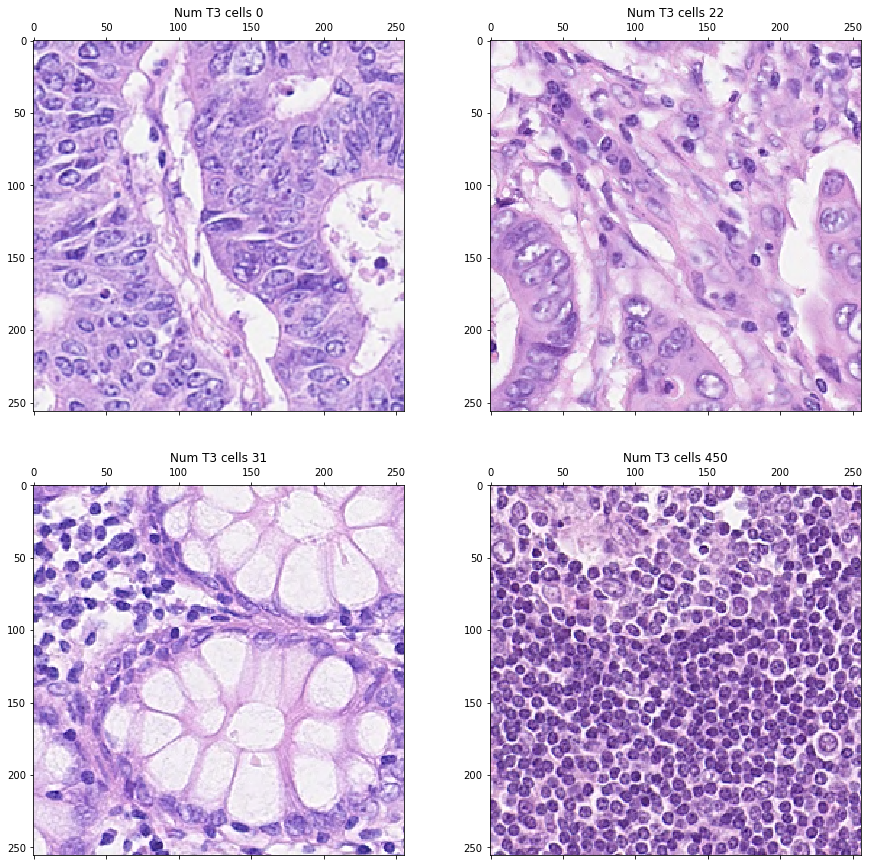

In [5]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(15,15))
ax1.matshow(X[0])
ax1.set_title('Num T3 cells '+str(Y.loc[0,'lymphocyte']))
ax2.matshow(X[200])
ax2.set_title('Num T3 cells '+str(Y.loc[200,'lymphocyte']))
ax3.matshow(X[10])
ax3.set_title('Num T3 cells '+str(Y.loc[10,'lymphocyte']))
ax4.matshow(X[308])
ax4.set_title('Num T3 cells '+str(Y.loc[308,'lymphocyte']))

### (iii) For each fold, plot the histogram of counts of each cell type separately (6 plots in total). How many images have counts within each of the following bins?

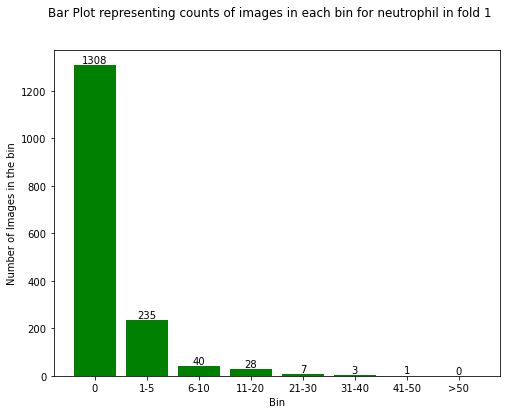

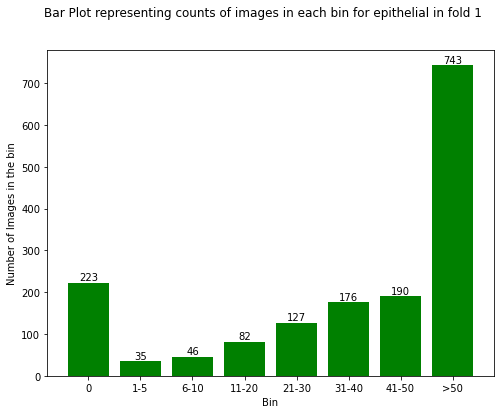

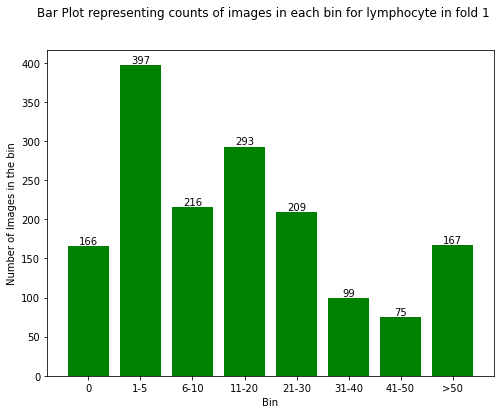

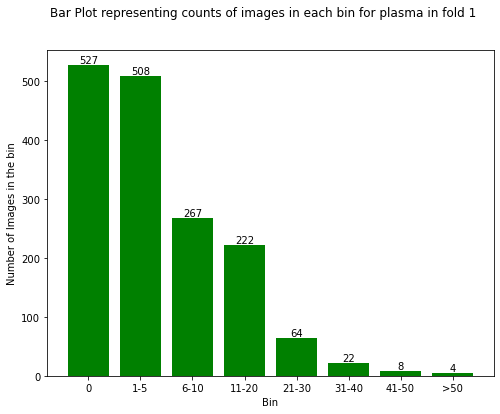

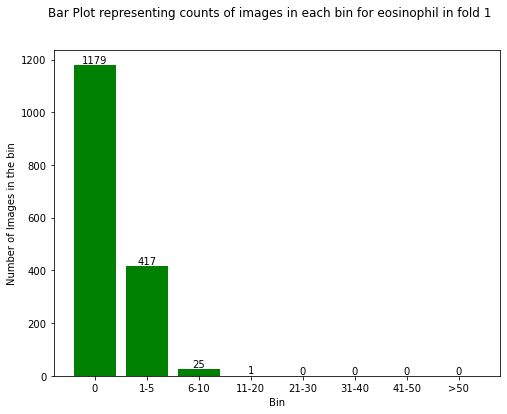

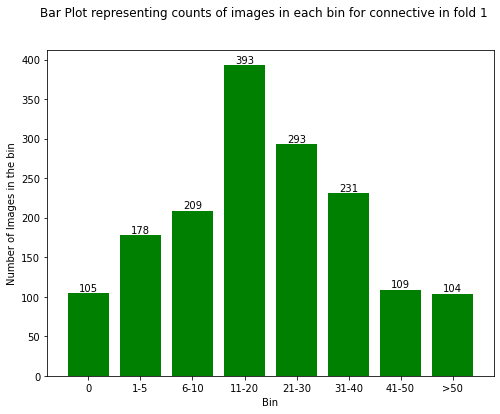

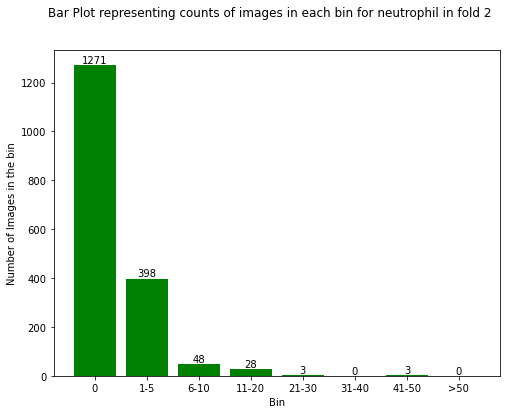

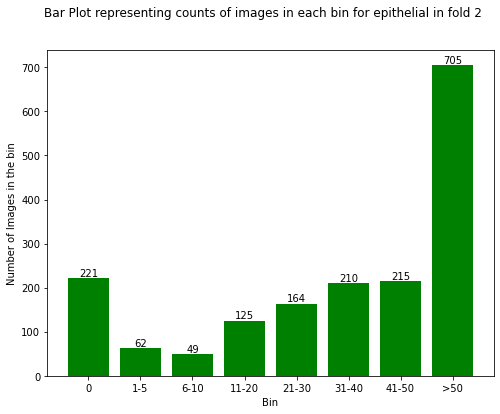

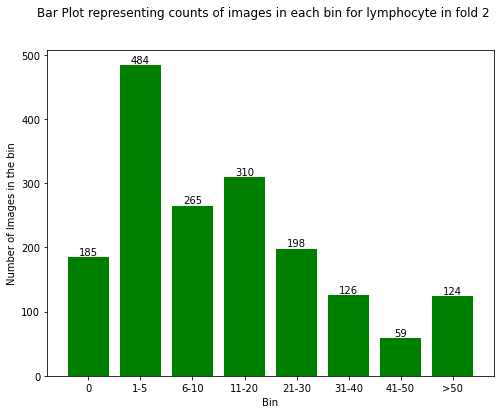

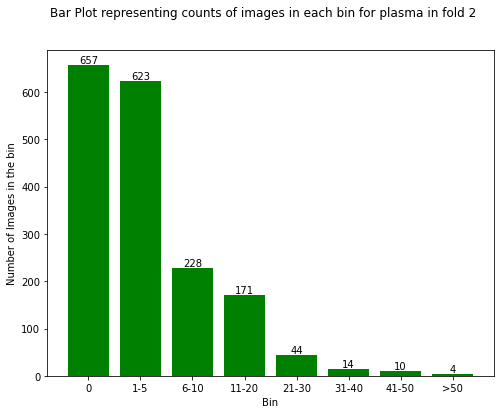

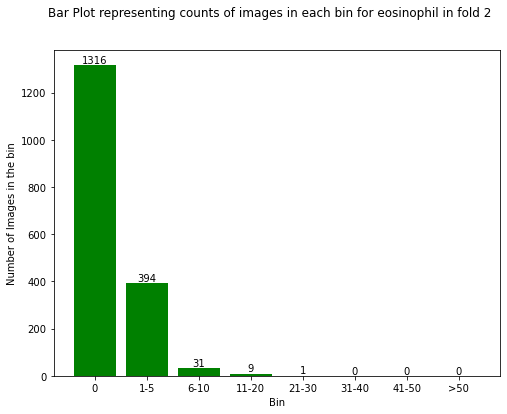

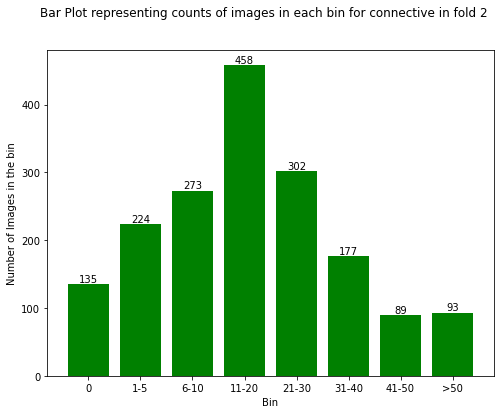

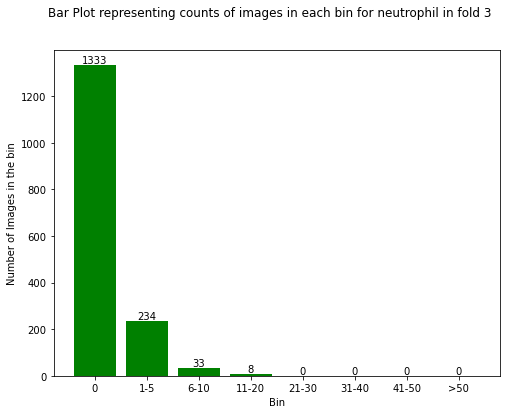

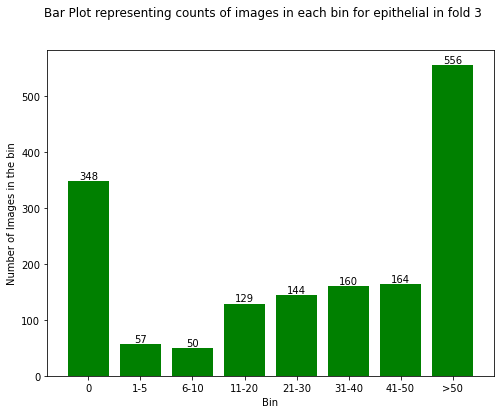

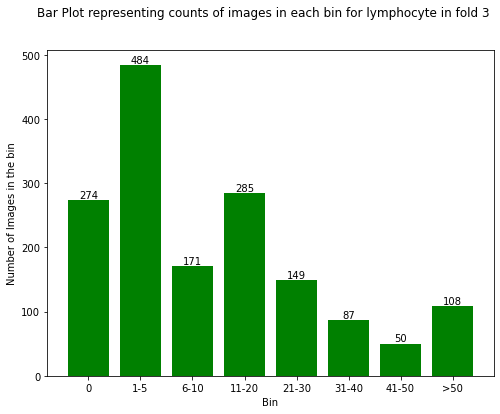

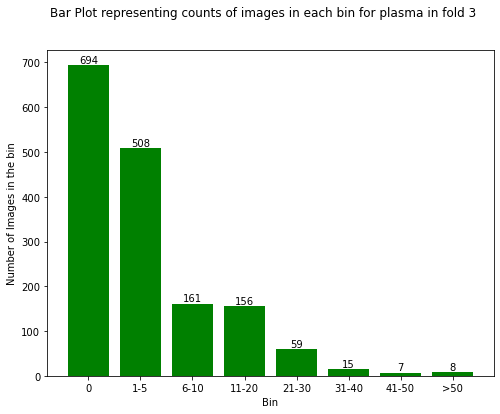

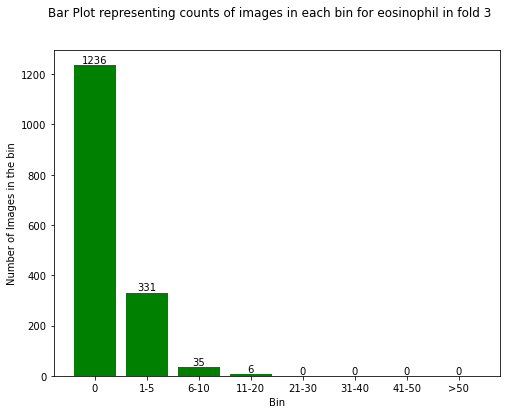

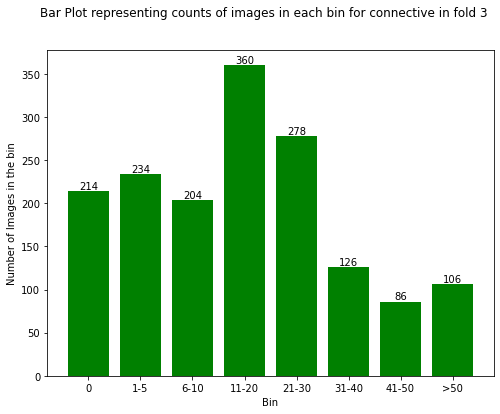

In [6]:
for fold in range(1,4):
    for col in Y.columns:
        historgram_cuts = ['0','1-5','6-10','11-20','21-30','31-40','41-50','>50']
        dict_plot = pd.cut(Y.loc[np.where(F==fold,)][col],bins=[-np.inf,0,5,10,20,30,40,50,np.inf],right=True,
               labels=historgram_cuts).value_counts().to_dict()
        values = [dict_plot.get(k) for k in historgram_cuts]
        fig = plt.figure(figsize=(8,6))
        bar1 = plt.bar(historgram_cuts, values, color='g',)
        fig.suptitle('Bar Plot representing counts of images in each bin for %s in fold %d'%(col,fold))
        plt.xlabel('Bin')
        plt.ylabel('Number of Images in the bin')
        for rect in bar1:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

### (iv) Pre-processing: Convert and show a few images from RGB space to HED space and show the H-channel which should indicate cellular nuclei.

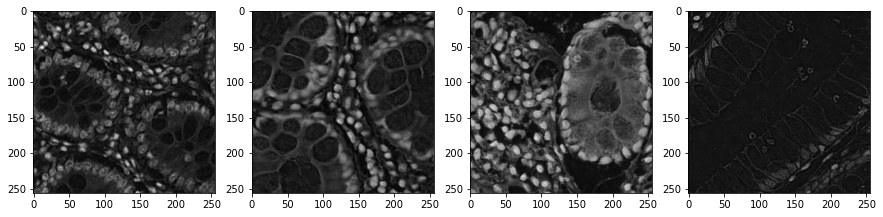

In [7]:
def plot_hed_h(image):
    return rgb2hed(image)[:, :, 0]
rand_num = np.random.randint(0,4981,4)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(15,15))
ax1.imshow(plot_hed_h(X[rand_num[0]]),cmap='gray')
ax2.imshow(plot_hed_h(X[rand_num[1]]),cmap='gray')
ax3.imshow(plot_hed_h(X[rand_num[2]]),cmap='gray')
ax4.imshow(plot_hed_h(X[rand_num[3]]),cmap='gray')

### (iv) Do a scatter plot of the average of the H-channel for each image vs. its cell count of a certain type for images in Fold-1 (6 plots in total). Do you think this feature would be useful in your regression model? Explain your reasoning.

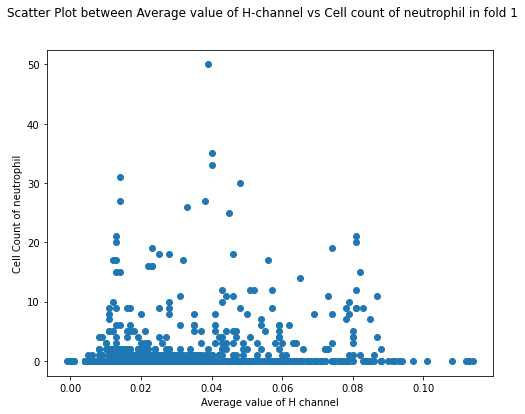

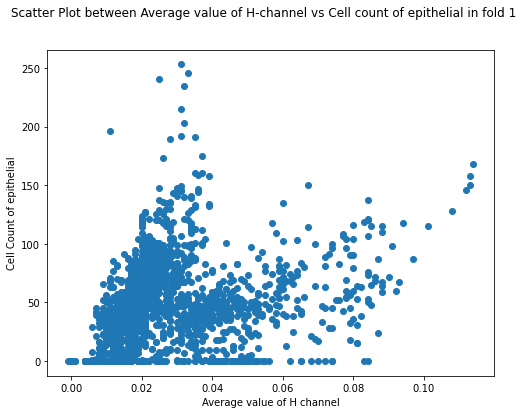

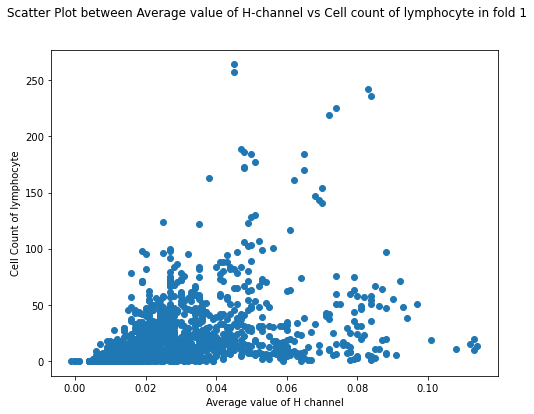

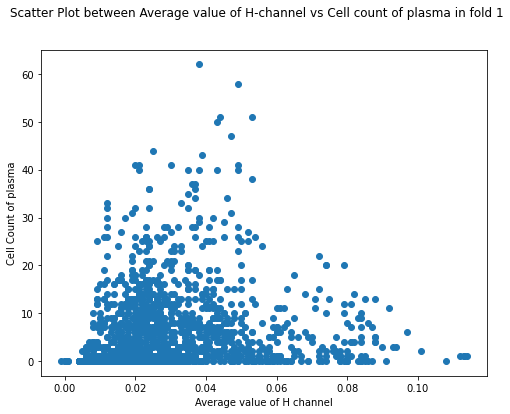

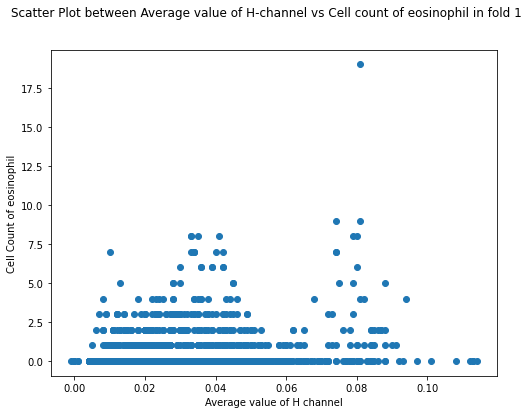

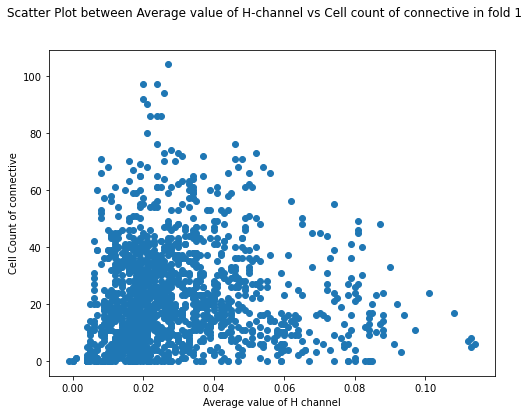

In [32]:
fold_1_data = X[np.where(F==1,)]
y_fold_1 = Y.loc[np.where(F==1,)]
h_data_x = [round(plot_hed_h(x).mean(),3) for x in fold_1_data]

for col in Y.columns:
    fig = plt.figure(figsize=(8,6))
    plt.scatter(h_data_x,y_fold_1[col].values)
    fig.suptitle('Scatter Plot between Average value of H-channel vs Cell count of %s in fold 1'%(col))
    plt.xlabel('Average value of H channel')
    plt.ylabel('Cell Count of %s'%col)

In [33]:
y_fold_1['avg_h_channel'] = h_data_x
y_fold_1.corr()['avg_h_channel']

neutrophil       0.142195
epithelial       0.252244
lymphocyte       0.376658
plasma           0.128577
eosinophil       0.202323
connective       0.057083
avg_h_channel    1.000000
Name: avg_h_channel, dtype: float64

According to pearson correlation between the feature i.e. average of H-channel and counts of different cell types, the feature can be useful because it has a good linear relationship with epithelial, lymphocyte and eosinophil cells and decent relationship with neutrophil and plasma. But it does not have a linear relationship with connective cells. 
I also tried to scale both the Cell count data and H-channel data into 0-1 range but there was no change in the correlation values and plots. 

### (vi) What performance metrics can you use for this problem? Which one will be the best performance metric for this problem? Please give reasoning.

Expecting that we are predicting values for all types of cells, it makes the problem a multiclass regression prpblem. Multiclass because I believe the number of cells of different types in a image don't affect each other, and regression because the output variable i.e. number of cells is a continuous variable.<br>
To assess the peformance of different models to predict the number of cells of an indivisual cell type there could be a number of metrics such as R2 (R-square), MSE (Mean Square Error) or RMSE (Root Mean Square Error) and some other as well.<br>The value of R2 (R-square) can range from negative to 1. It is the ratio of Variance captured by the model to the total variance in the y or the features whose values are to be predicted. The total variance in y can be explained as sum of MSE and Total variance in y. Since the total variance in the model is constant, if the variance captured in the model increases the MSE decreases. We could optimise the model using MSE but R2 (R-square) is more interpretable then MSE because it is bounded (max value is 1) vs the MSE whose values are much larger than unbounded. At the same time it could be hard to optimise the model using R2 (R-square) because the change in the two models would be not visible clearly. RMSE could also be a good option because it's values are smaller compared to MSE but, it's also unbounded. <br>
The answer remains unclear, but If I am building a single model and I have to comment on it, I would use R2 (R-square) because it is bounded, but if I am comparing two models I would rather use RMSE. 

## Question No. 2: (Feature Extraction and Classical Regression)

### (i) i. Extract features from a given image. Specifically, calculate the: <br>
a. average of the “H”, red, green and blue channels<br>
b. variance of the “H”, red, green and blue channels<br>
c. entropy of the “H”, red, green and blue channels<br>
d. Any other features that you think can be useful for this work. Describe your reasoning for using these features.

In [5]:
from sklearn.decomposition import PCA
from skimage.measure import shannon_entropy
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr,pearsonr

In [6]:
N_COMP = 1
red_X = X[:,:,:,0] ## PCA on Indivisual R channel
avg_red = red_X.mean(axis=(-1,-2)) # average of R channel 
var_red = red_X.var(axis=(-1,-2)) # var of R channel 
ent_red =  [ shannon_entropy(x) for x in red_X ] # entropy of R channel 
red_X = red_X.reshape(4981,256*256)
pca = PCA(n_components= N_COMP)
pca_red_data = pca.fit_transform(red_X) # PCA on R channel 
del red_X
print('Processing of R channel done')

green_X = X[:,:,:,1] ## PCA on Indivisual G channel
avg_green = green_X.mean(axis=(-1,-2)) # average of G channel 
var_green = green_X.var(axis=(-1,-2)) # var of G channel 
ent_green =  [ shannon_entropy(x) for x in green_X ]  # entropy of G channel 
green_X = green_X.reshape(4981,256*256)
pca = PCA(n_components= N_COMP)
pca_green_data = pca.fit_transform(green_X) # PCA on G channel 
del green_X
print('Processing of G channel done')

blue_X = X[:,:,:,2] ## PCA on Indivisual G channel
avg_blue = blue_X.mean(axis=(-1,-2)) # average of B channel 
var_blue = blue_X.var(axis=(-1,-2)) # var of B channel 
ent_blue =  [ shannon_entropy(x) for x in blue_X ]  # entropy of B channel 
blue_X = blue_X.reshape(4981,256*256) ## PCA on Indivisual B channel
pca = PCA(n_components= N_COMP)
pca_blue_data = pca.fit_transform(blue_X)
del blue_X
print('Processing of B channel done')

mean_X = np.mean(X,axis=-1) ## Average of RGB  channel
avg_rgb = mean_X.mean(axis=(-1,-2)) # average of RGB channel 
var_rgb = mean_X.var(axis=(-1,-2)) # var of RGB 
ent_rgb =  [ shannon_entropy(x) for x in mean_X ]  # entropy of Mean of RGB
mean_X = mean_X.reshape(4981,256*256) ## PCA on Indivisual B channel
pca = PCA(n_components= N_COMP)
pca_rgb_data = pca.fit_transform(mean_X)
del mean_X
print('Processing of RGB done')

hed_X = np.array([rgb2hed(x) for x in X])  ## Convert RGB into hed

hed_h = hed_X[:,:,:,0] 
avg_h = hed_h.mean(axis=(-1,-2)) ## Average of H  channel
var_h = hed_h.var(axis=(-1,-2)) # var of H channel 
ent_h =  [ shannon_entropy(x) for x in hed_h ]  # entropy of H channel 
hed_h = hed_h.reshape(4981,256*256)
pca = PCA(n_components= N_COMP)
pca_h_data = pca.fit_transform(hed_h)
del hed_h
print('Processing of H done')

hed_e = hed_X[:,:,:,1]
avg_e = hed_e.mean(axis=(-1,-2)) ## Average of E  channel
var_e = hed_e.var(axis=(-1,-2)) # var of E channel 
ent_e =  [ shannon_entropy(x) for x in hed_e ]  # entropy of E channel 
hed_e = hed_e.reshape(4981,256*256)
pca = PCA(n_components= N_COMP)
pca_e_data = pca.fit_transform(hed_e)
del hed_e
print('Processing of E done')

hed_d = hed_X[:,:,:,2]
avg_d = hed_d.mean(axis=(-1,-2)) ## Average of D channel
var_d = hed_d.var(axis=(-1,-2)) # var of D channel 
ent_d =  [ shannon_entropy(x) for x in hed_d ]  # entropy of D channel 
hed_d = hed_d.reshape(4981,256*256)
pca = PCA(n_components= N_COMP)
pca_d_data = pca.fit_transform(hed_d)
del hed_d
print('Processing of D done')

mean_hed_X = np.mean(hed_X,axis=-1) ## Average of HED 
avg_hed = mean_hed_X.mean(axis=(-1,-2)) # mean of HED channel 
var_hed = mean_hed_X.var(axis=(-1,-2)) # var of HED channel 
ent_hed =  [ shannon_entropy(x) for x in mean_hed_X ] # entropy of mean of HED 
mean_hed_X = mean_hed_X.reshape(4981,256*256) ## PCA on HED
pca = PCA(n_components= N_COMP)
pca_hed_data = pca.fit_transform(mean_hed_X) # PCA on HED
del mean_hed_X
print('Processing of HED done')

del hed_X

Processing of R channel done
Processing of G channel done
Processing of B channel done
Processing of RGB done
Processing of H done
Processing of E done
Processing of D done
Processing of HED done


Some additional features were created on the lines of the mentioned features, and first principal components was extracted from each of the features. These features proved to be efficient because they decreased the Error and improved other metrics and had positive coorelation with the target variable

In [135]:
features_df = pd.DataFrame()
features_df['AVG_RED'] = avg_red
features_df['VAR_RED'] = var_red
features_df['ENT_RED'] = ent_red
features_df['PCA_RED'] = pca_red_data

features_df['AVG_GREEN'] = avg_green
features_df['VAR_GREEN'] = var_green
features_df['ENT_GREEN'] = ent_green
features_df['PCA_GREEN'] = pca_green_data

features_df['AVG_BLUE'] = avg_blue
features_df['VAR_BLUE'] = var_blue
features_df['ENT_BLUE'] = ent_blue
features_df['PCA_BLUE'] = pca_blue_data

features_df['AVG_RGB'] = avg_rgb
features_df['VAR_RGB'] = var_rgb
features_df['ENT_RGB'] = ent_rgb
features_df['PCA_RGB'] = pca_rgb_data

features_df['AVG_H'] = avg_h
features_df['VAR_H'] = var_h
features_df['ENT_H'] = ent_h
features_df['PCA_H'] = pca_h_data

features_df['AVG_E'] = avg_e
features_df['VAR_E'] = var_e
features_df['ENT_E'] = ent_e
features_df['PCA_E'] = pca_e_data

features_df['AVG_D'] = avg_d
features_df['VAR_D'] = var_d
features_df['ENT_D'] = ent_d
features_df['PCA_D'] = pca_d_data

features_df['AVG_HED'] = avg_hed
features_df['VAR_HED'] = var_hed
features_df['ENT_HED'] = ent_hed
features_df['PCA_HED'] = pca_hed_data

features_df['TARGET'] = Y['lymphocyte']

In [118]:
features_df.corr()['TARGET']

AVG_RED     -0.360468
VAR_RED      0.401639
ENT_RED      0.320366
PCA_RED      0.360437
AVG_GREEN   -0.385670
VAR_GREEN    0.128848
ENT_GREEN    0.215746
PCA_GREEN    0.385638
AVG_BLUE    -0.375746
VAR_BLUE     0.242062
ENT_BLUE     0.287921
PCA_BLUE     0.375728
AVG_RGB     -0.383295
VAR_RGB      0.258209
ENT_RGB      0.269062
PCA_RGB      0.383263
AVG_H        0.330425
VAR_H        0.439914
ENT_H        0.207158
PCA_H        0.330383
AVG_E        0.325274
VAR_E        0.155810
ENT_E        0.206947
PCA_E        0.325206
AVG_D        0.313963
VAR_D        0.054994
ENT_D        0.207221
PCA_D        0.313691
AVG_HED      0.387216
VAR_HED      0.325273
ENT_HED      0.207155
PCA_HED      0.387176
TARGET       1.000000
Name: TARGET, dtype: float64

C:\Users\raghu\AppData\Local\Temp/ipykernel_8316/3830521790.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8,6))


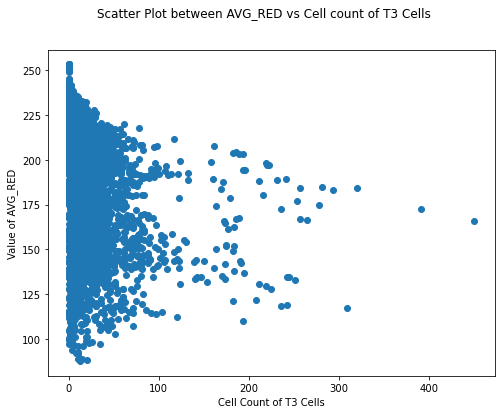

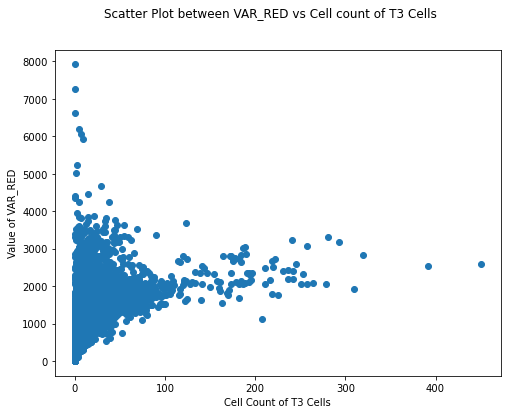

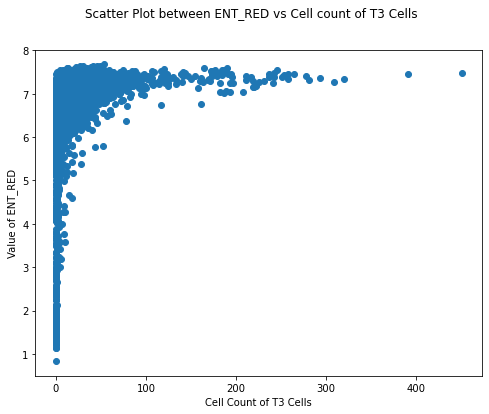

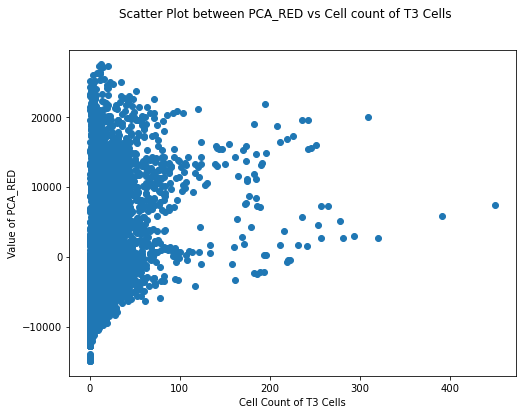

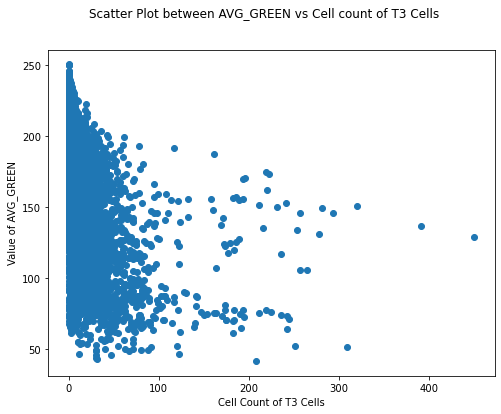

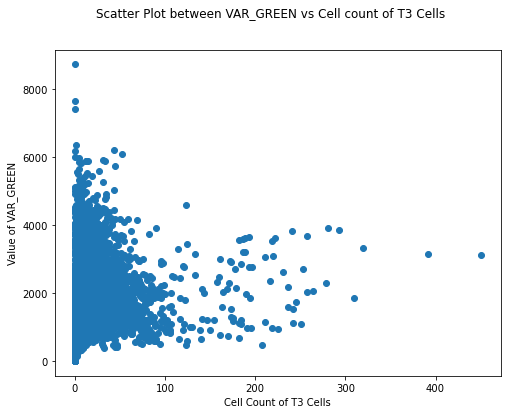

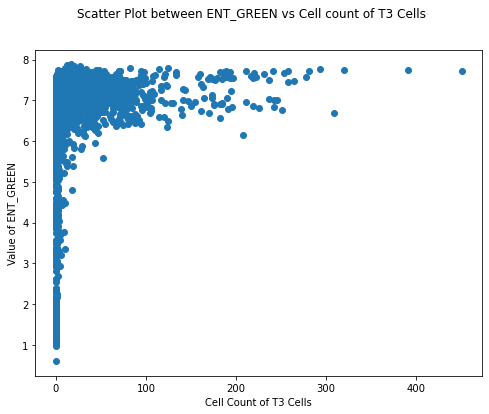

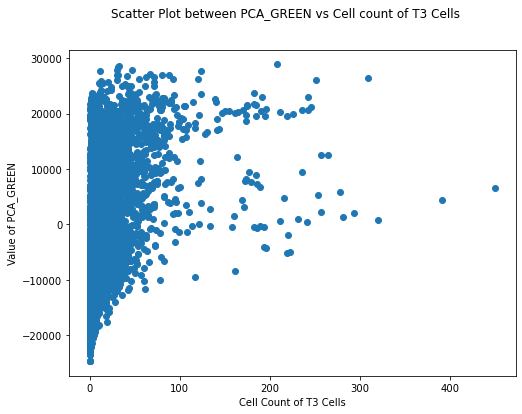

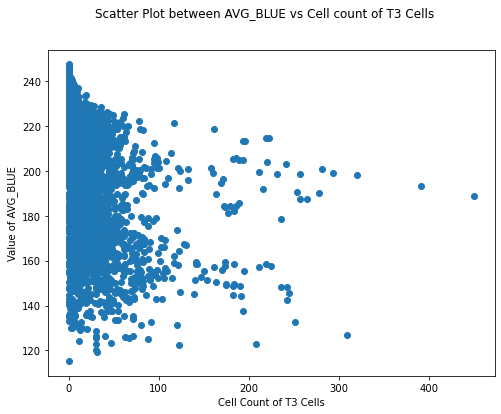

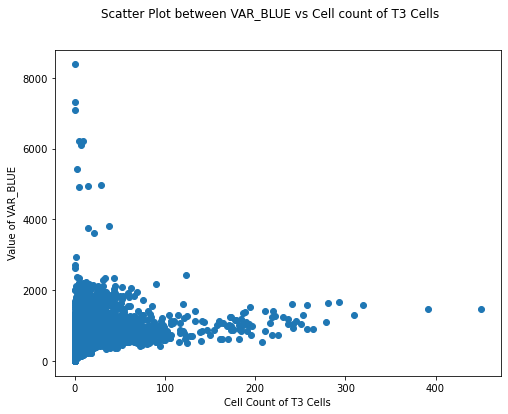

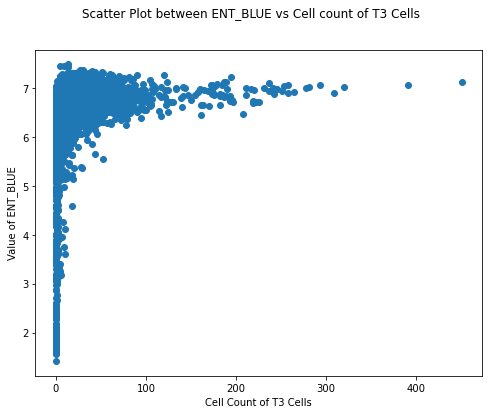

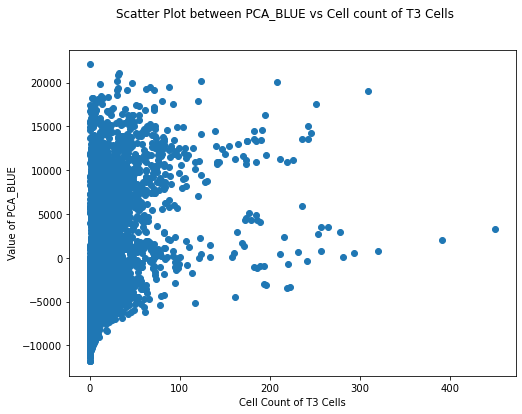

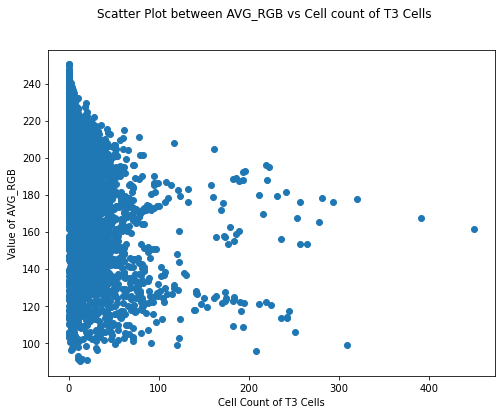

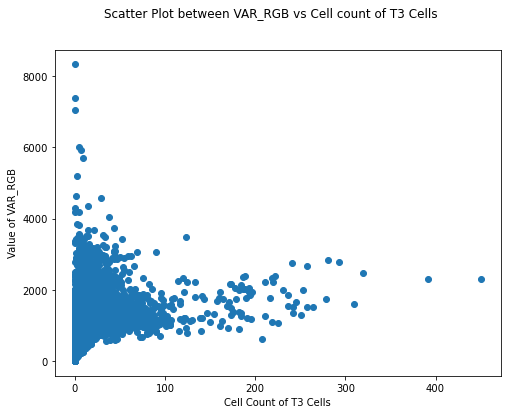

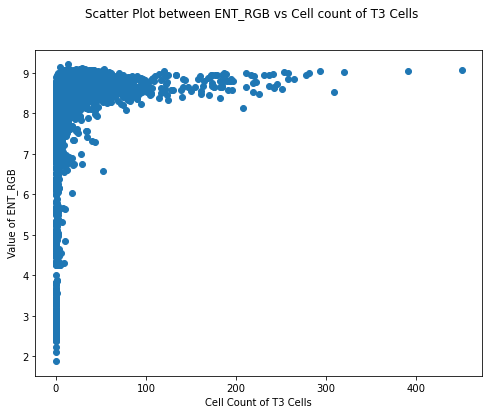

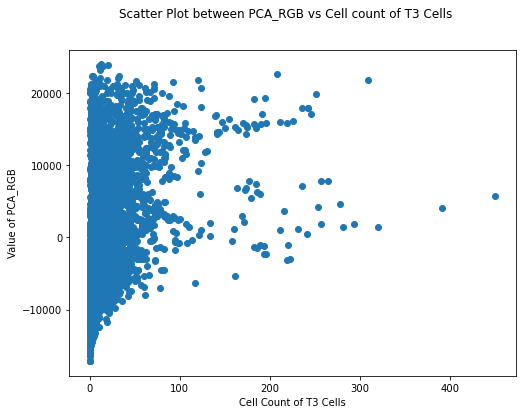

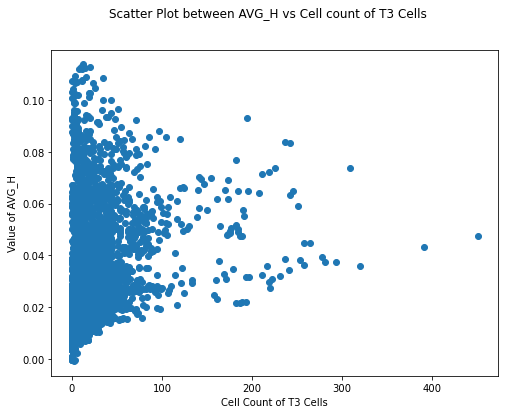

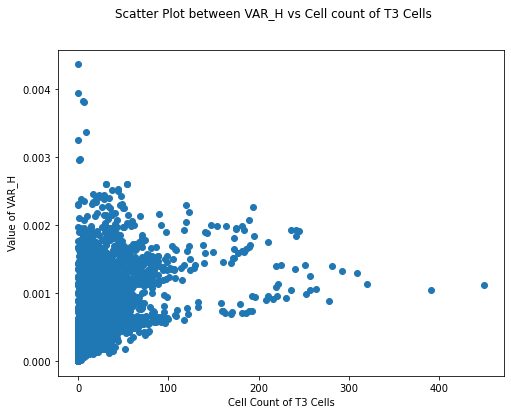

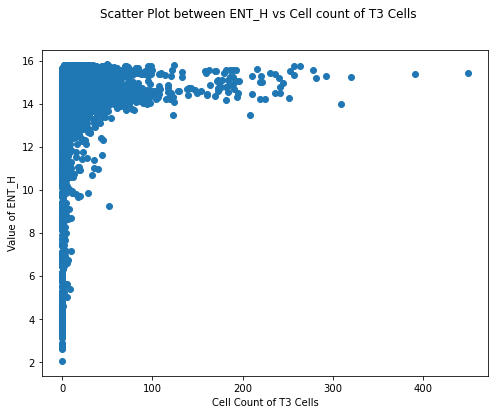

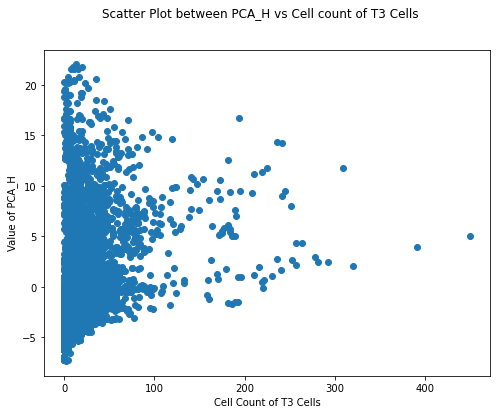

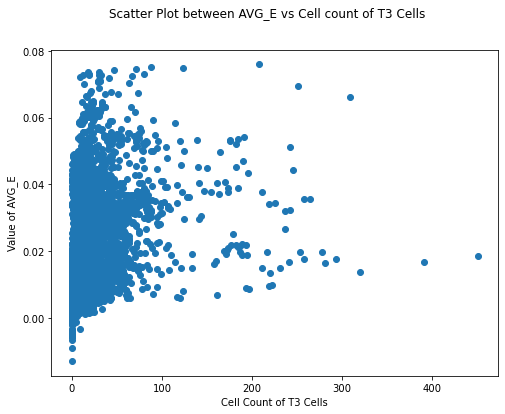

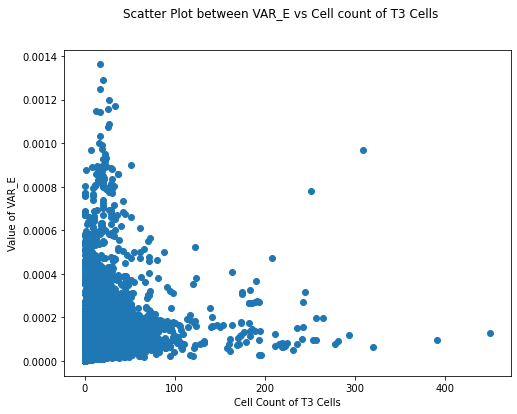

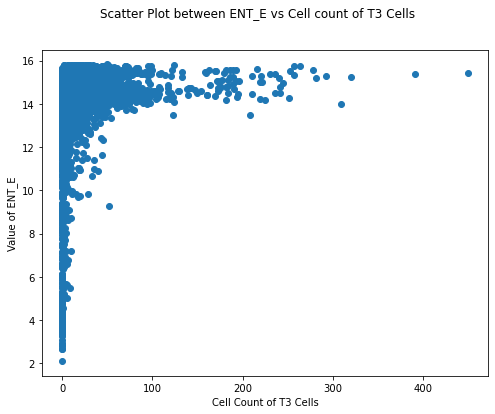

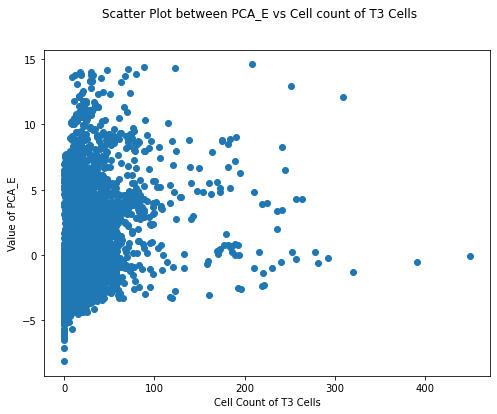

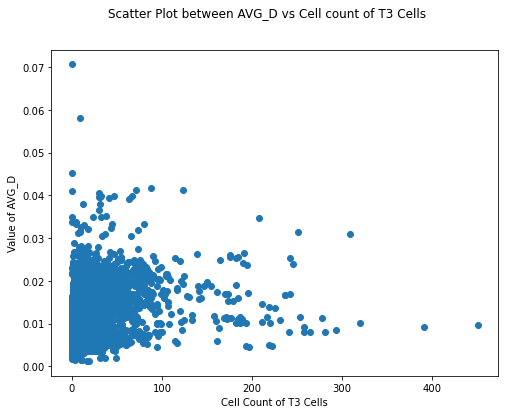

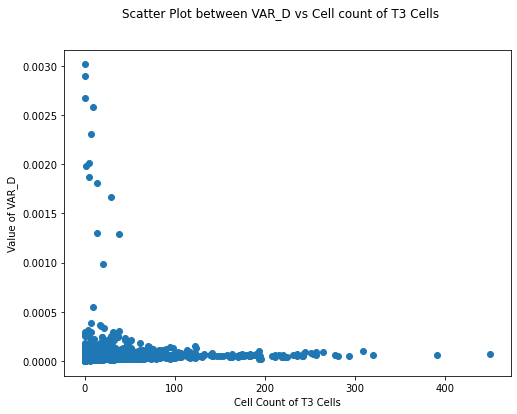

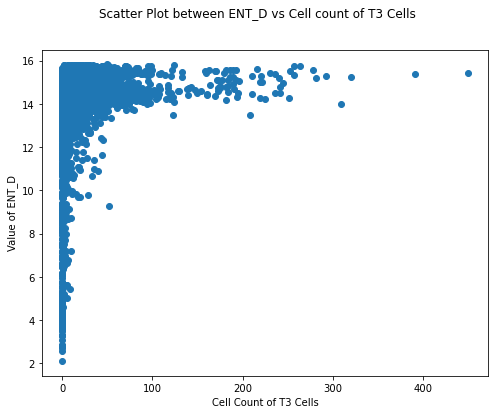

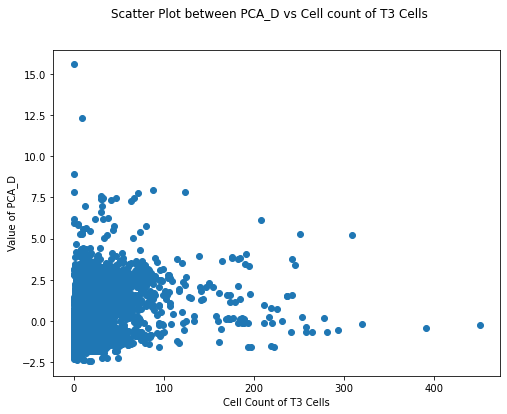

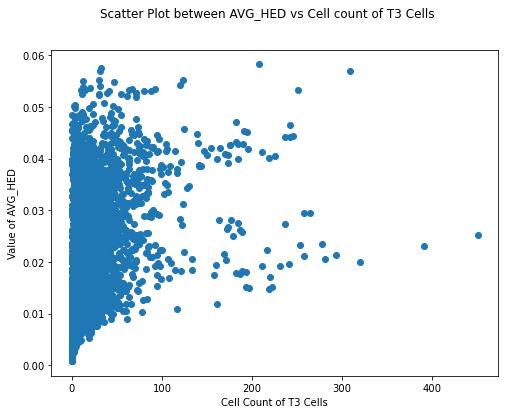

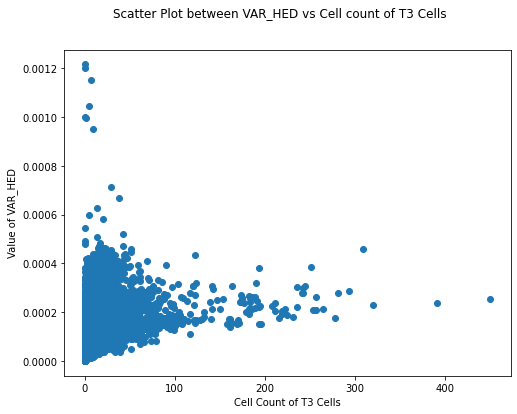

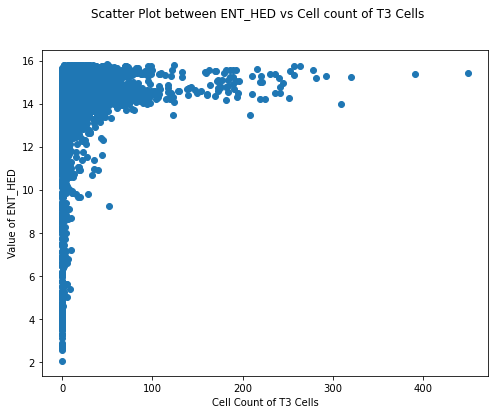

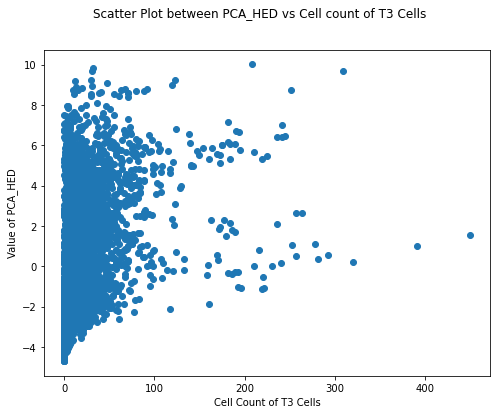

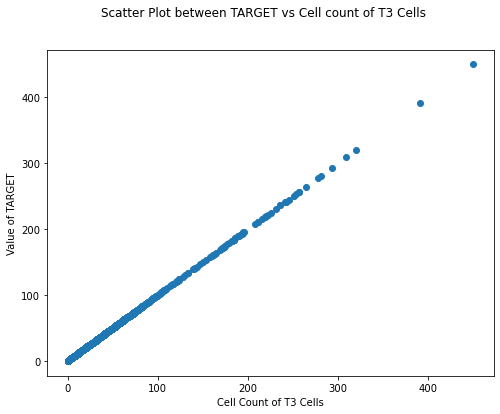

In [8]:
for col in features_df.columns:
    fig = plt.figure(figsize=(8,6))
    plt.scatter(features_df['TARGET'],features_df[col].values)
    fig.suptitle('Scatter Plot between %s vs Cell count of T3 Cells'%(col))
    plt.xlabel('Cell Count of T3 Cells')
    plt.ylabel('Value of %s'%(col))


In [136]:
features_df['TARGET'] = StandardScaler().fit_transform(features_df['TARGET'].values.reshape(-1,1))

In [137]:
train_data_X = features_df.loc[np.where(F!=1,)].drop('TARGET',axis=1)
train_data_y = features_df.loc[np.where(F!=1,),'TARGET']

test_data_X = features_df.loc[np.where(F==3,)].drop('TARGET',axis=1)
test_data_y = features_df.loc[np.where(F==3,),'TARGET']

In [153]:
svr = make_pipeline(StandardScaler(),SVR()) #Standard Scaler improved the scores too 
svr.fit(train_data_X,train_data_y)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())])

In [154]:
test_predictions = svr.predict(test_data_X)
print("RMSE for the Test data is",np.sqrt(mean_squared_error(test_data_y,test_predictions)))
print("Pearson Correlation coefficient for Test Data is",pearsonr(test_data_y,test_predictions)[0])
print("Spearman Correlation coefficient for Test Data is",spearmanr(test_data_y,test_predictions)[0])
print('R-Square for the Test data is',r2_score(test_data_y,test_predictions.reshape(-1)))

RMSE for the Test data is 0.6569836316326433
Pearson Correlation coefficient for Test Data is 0.7573271165934261
Spearman Correlation coefficient for Test Data is 0.8247131649174573
R-Square for the Test data is 0.5376048126689841


Text(0, 0.5, 'True')

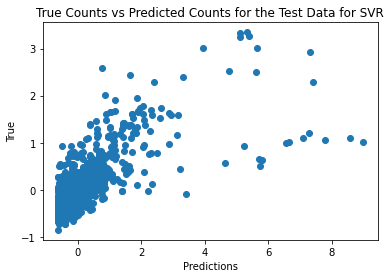

In [155]:
plt.scatter(test_data_y,test_predictions,)
plt.title('True Counts vs Predicted Counts for the Test Data for SVR')
plt.xlabel('Predictions')
plt.ylabel('True')

In [156]:
from sklearn.linear_model import LinearRegression

In [157]:
ols = make_pipeline(StandardScaler(),LinearRegression()) #Standard Scaler improved the scores too 
ols.fit(train_data_X,train_data_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [158]:
test_predictions = ols.predict(test_data_X)
print("RMSE for the Test data is",np.sqrt(mean_squared_error(test_data_y,test_predictions)))
print("Pearson Correlation coefficient for Test Data is",pearsonr(test_data_y,test_predictions)[0])
print("Spearman Correlation coefficient for Test Data is",spearmanr(test_data_y,test_predictions)[0])
print('R-Square for the Test data is',r2_score(test_data_y,test_predictions.reshape(-1)))

RMSE for the Test data is 0.7613535192040541
Pearson Correlation coefficient for Test Data is 0.62394262628199
Spearman Correlation coefficient for Test Data is 0.6171271811902889
R-Square for the Test data is 0.3790209833614392


Text(0, 0.5, 'True')

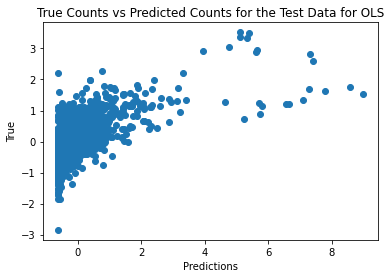

In [159]:
plt.scatter(test_data_y,test_predictions,)
plt.title('True Counts vs Predicted Counts for the Test Data for OLS')
plt.xlabel('Predictions')
plt.ylabel('True')

## QUestion 3

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import float32
from tensorflow_addons.metrics import RSquare

import seaborn as sns
from scipy.special import inv_boxcox1p
from scipy.stats import boxcox
from skimage.transform import resize
from cv2 import equalizeHist,merge,split

In [8]:
IMG_SIZE = (128,128,3)
BATCH = 25
def equalise_resize(img): ## Histogram Equalisation to improve contrast between the images and resize to lower the size
    R, G, B = split(img)
    output1_R = equalizeHist(R)
    output1_G = equalizeHist(G)
    output1_B = equalizeHist(B)
    return resize(merge((output1_R, output1_G, output1_B)), IMG_SIZE)

In [259]:
X = [ equalise_resize(x) for x in X ]
X = np.array(X)

target_data = Y['lymphocyte']
target_data,_ = boxcox(target_data+1)
target_data = MinMaxScaler().fit_transform(target_data.reshape(-1,1))

In [262]:
train_data_X = X[np.where(F==1,)]
train_data_y = target_data[np.where(F==1,)].reshape(-1)

validation_data_X = X[np.where(F==2,)]
validation_data_y = target_data[np.where(F==2,)].reshape(-1)

test_data_X = X[np.where(F==3,)]
test_data_y = target_data[np.where(F==3,)].reshape(-1)

del X

In [7]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
def prepare_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=IMG_SIZE,strides=1)) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (3, 3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))            
    model.add(Dropout(0.25))                     
    model.add(Flatten())                        
    model.add(Dense(128, activation='relu'))          
    model.add(Dropout(0.5))                   
    model.add(Dense(1, activation='linear'))
    model.compile(loss=root_mean_squared_error,optimizer="adam",metrics=[RSquare(dtype=float32, y_shape=(1,))],)
    return model

def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

In [264]:
datagen = ImageDataGenerator(rotation_range=10,
                             horizontal_flip=True, 
                             vertical_flip=True,
                            preprocessing_function=orthogonal_rot,)
test_datagen = ImageDataGenerator()

In [265]:
training_generator = datagen.flow(train_data_X,train_data_y, batch_size=BATCH)
valid_generator = datagen.flow(x=validation_data_X, y=validation_data_y, batch_size=BATCH)
test_generator = test_datagen.flow(x=test_data_X, y=test_data_y, batch_size=BATCH)

In [267]:
model = prepare_model()

In [268]:
hist = model.fit(training_generator,validation_data=valid_generator,epochs=50,callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5,restore_best_weights=True)])

Epoch 1/50
65/65 [==============================] - 14s 209ms/step - loss: 0.3124 - r_square: -5.8041 - val_loss: 0.1910 - val_r_square: 0.1087
Epoch 2/50
65/65 [==============================] - 13s 200ms/step - loss: 0.1855 - r_square: 0.1782 - val_loss: 0.1857 - val_r_square: 0.1531
Epoch 3/50
65/65 [==============================] - 13s 196ms/step - loss: 0.1823 - r_square: 0.1947 - val_loss: 0.1775 - val_r_square: 0.2276
Epoch 4/50
65/65 [==============================] - 13s 201ms/step - loss: 0.1606 - r_square: 0.3858 - val_loss: 0.1706 - val_r_square: 0.2821
Epoch 5/50
65/65 [==============================] - 14s 216ms/step - loss: 0.1499 - r_square: 0.4627 - val_loss: 0.1384 - val_r_square: 0.5264
Epoch 6/50
65/65 [==============================] - 14s 218ms/step - loss: 0.1504 - r_square: 0.4542 - val_loss: 0.1380 - val_r_square: 0.5292
Epoch 7/50
65/65 [==============================] - 13s 208ms/step - loss: 0.1391 - r_square: 0.5388 - val_loss: 0.1448 - val_r_square: 0.484

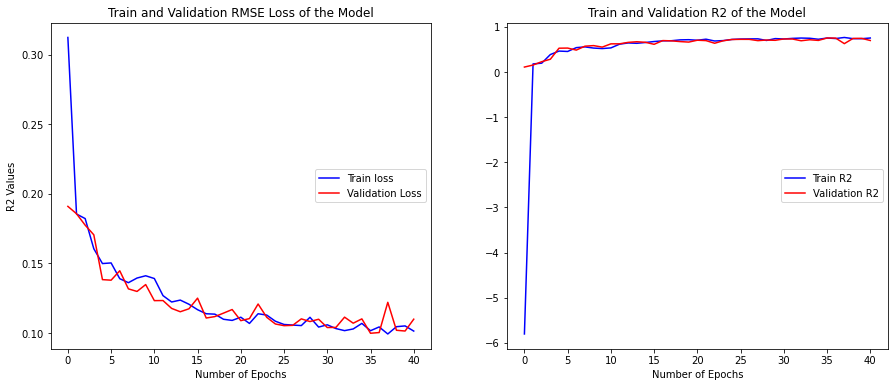

In [299]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15,6))

ax1.plot(hist.epoch,hist.history['loss'],c='blue',label='Train loss')
ax1.plot(hist.epoch,hist.history['val_loss'],c='red',label='Validation Loss')
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('RMSE Loss')
ax1.set_title('Train and Validation RMSE Loss of the Model')
ax1.legend(loc="center right")

ax2.plot(hist.epoch,hist.history['r_square'],c='blue',label='Train R2')
ax2.plot(hist.epoch,hist.history['val_r_square'],c='red',label='Validation R2')
ax2.set_xlabel('Number of Epochs')
ax1.set_ylabel('R2 Values')
ax2.set_title('Train and Validation R2 of the Model')
ax2.legend(loc="center right")

In [294]:
validation_predictions = model.predict(validation_data_X)
print("RMSE for the Validation data is",np.sqrt(mean_squared_error(validation_data_y,validation_predictions)))
print("Pearson Correlation coefficient for Validation Data is",pearsonr(validation_data_y,validation_predictions.reshape(-1))[0])
print("Spearman Correlation coefficient for Validation Data is",spearmanr(validation_data_y,validation_predictions.reshape(-1))[0])
print('R-Square for the Validation data is',r2_score(validation_data_y,validation_predictions.reshape(-1)))
print()
test_predictions = model.predict(test_data_X)
print("RMSE for the Validation data is",np.sqrt(mean_squared_error(test_data_y,test_predictions)))
print("Pearson Correlation coefficient for Validation Data is",pearsonr(test_data_y,test_predictions.reshape(-1))[0])
print("Spearman Correlation coefficient for Validation Data is",spearmanr(test_data_y,test_predictions.reshape(-1))[0])
print('R-Square for the Validation data is',r2_score(test_data_y,test_predictions.reshape(-1)))

RMSE for the Validation data is 0.12969051414176236
Pearson Correlation coefficient for Validation Data is 0.8496941940268097
Spearman Correlation coefficient for Validation Data is 0.8416445766901546
R-Square for the Validation data is 0.5937251621875467


Text(0.5, 1.0, 'True Counts vs Predicted Counts for the Test Data')

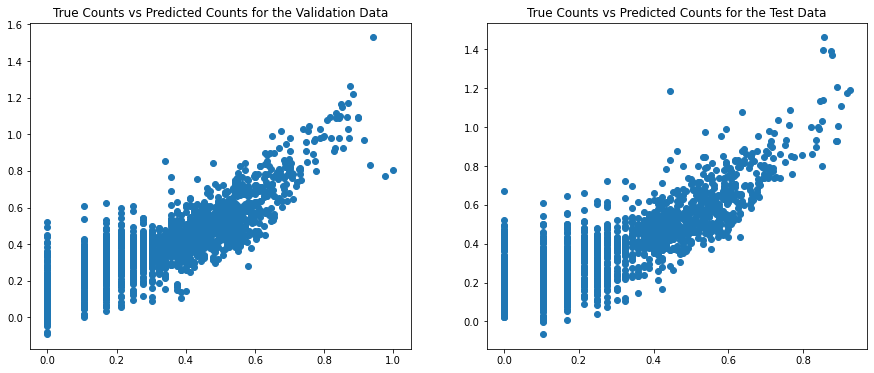

In [296]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15,6))

ax1.scatter(validation_data_y,validation_predictions)
ax1.set_title('True Counts vs Predicted Counts for the Validation Data')

ax2.scatter(test_data_y,test_predictions)
ax2.set_title('True Counts vs Predicted Counts for the Test Data')

In [11]:
X = np.load(BASE_DIR + "images.npy")#read images
Y = pd.read_csv(BASE_DIR + 'counts.csv')#read cell counts
F = np.loadtxt(BASE_DIR + 'split.txt')#read fold information

IMG_SIZE = (128,128,3)
X = [ equalise_resize(x) for x in X ]
X = np.array(X)

target_data = Y['lymphocyte']
target_data,_ = boxcox(target_data+1)
target_data = MinMaxScaler().fit_transform(target_data.reshape(-1,1))

In [12]:
from sklearn.model_selection import train_test_split

Test data used for this fold is 1
Restoring model weights from the end of the best epoch: 28.
Epoch 33: early stopping
RMSE for the Testing data is 0.10199505547256582
Pearson Correlation coefficient for Testing Data is 0.873842039259187
Spearman Correlation coefficient for Testing Data is 0.8792080651145617
R-Square for the Testing data is 0.7571776874586905
************ End of Fold 1 ************

Test data used for this fold is 2
Restoring model weights from the end of the best epoch: 25.
Epoch 30: early stopping
RMSE for the Testing data is 0.10682048697614262
Pearson Correlation coefficient for Testing Data is 0.8631696054437992
Spearman Correlation coefficient for Testing Data is 0.855639721313314
R-Square for the Testing data is 0.7243788066738404
************ End of Fold 2 ************

Test data used for this fold is 3
Restoring model weights from the end of the best epoch: 20.
Epoch 25: early stopping
RMSE for the Testing data is 0.14869922959786963
Pearson Correlation coeffi

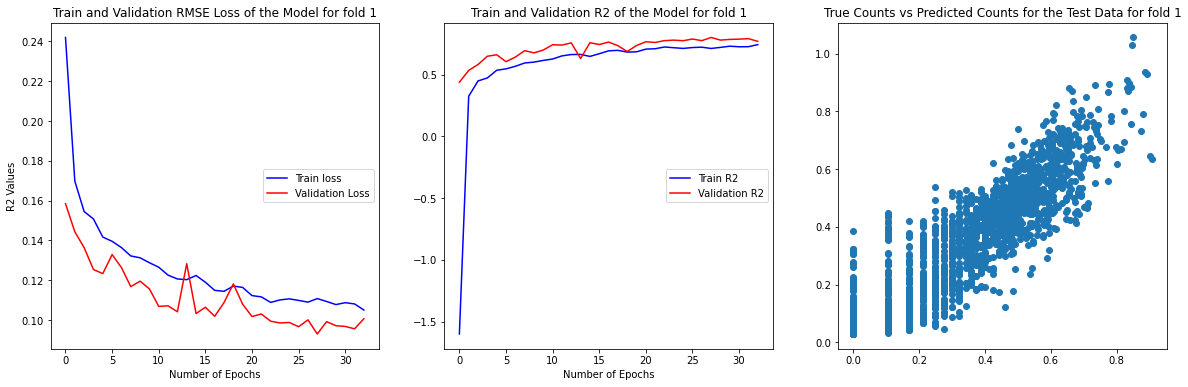

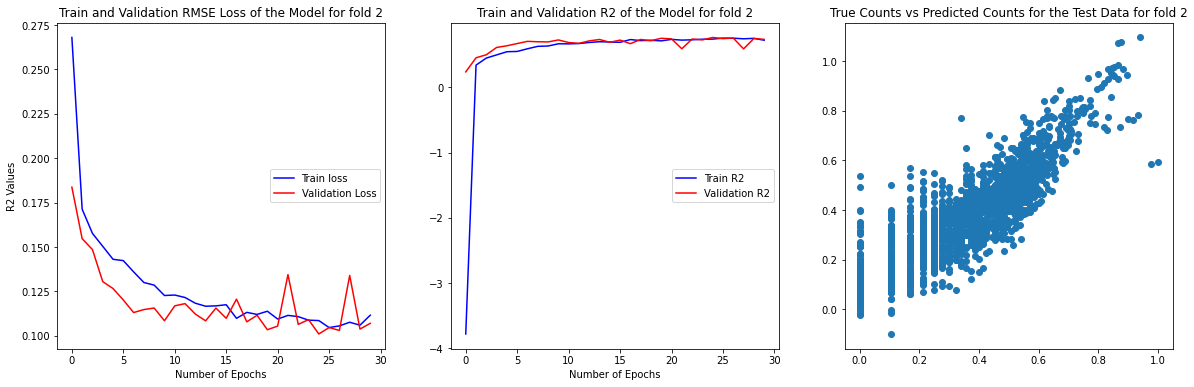

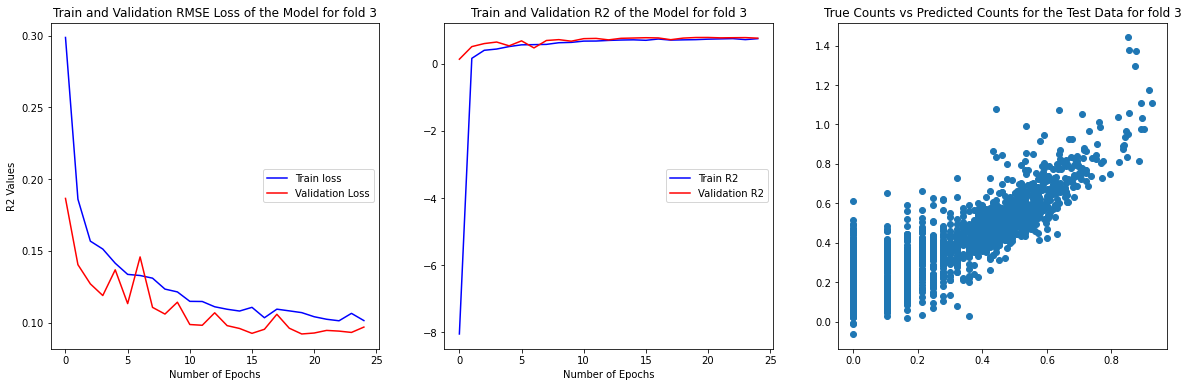

In [17]:
for fold in range(1,4):
    print('Test data used for this fold is %d'%(fold))
    test_data_x = X[np.where(F==fold,)]
    test_data_y = target_data[np.where(F==fold,)].reshape(-1)
    
    train_valid_data_x = X[np.where(F!=fold,)]
    train_valid_data_y = target_data[np.where(F!=fold,)].reshape(-1)
    
    datagen = ImageDataGenerator(rotation_range=10,
                             horizontal_flip=True, 
                             vertical_flip=True,
                            preprocessing_function=orthogonal_rot,validation_split=0.2,)
    test_datagen = ImageDataGenerator()
    
    train_data_X,validation_data_X,train_data_y,validation_data_y =  train_test_split(train_valid_data_x,train_valid_data_y,test_size=0.2)
    del train_valid_data_x,train_valid_data_y
    
    training_generator = datagen.flow(train_data_X,train_data_y, batch_size=BATCH)
    valid_generator = datagen.flow(x=validation_data_X, y=validation_data_y, batch_size=BATCH)
    test_generator = test_datagen.flow(x=test_data_x, y=test_data_y, batch_size=BATCH)
    
    model = prepare_model()
    hist = model.fit(training_generator, validation_data=valid_generator,epochs=50,verbose=0,
                     callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5,restore_best_weights=True)])
    
    test_predictions = model.predict(test_data_x)
    print("RMSE for the Testing data is",np.sqrt(mean_squared_error(test_data_y,test_predictions)))
    print("Pearson Correlation coefficient for Testing Data is",pearsonr(test_data_y,test_predictions.reshape(-1))[0])
    print("Spearman Correlation coefficient for Testing Data is",spearmanr(test_data_y,test_predictions.reshape(-1))[0])
    print('R-Square for the Testing data is',r2_score(test_data_y,test_predictions.reshape(-1)))
    print('************ End of Fold %d ************'%(fold))
    print()
    
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(20,6))
    ax1.plot(hist.epoch,hist.history['loss'],c='blue',label='Train loss')
    ax1.plot(hist.epoch,hist.history['val_loss'],c='red',label='Validation Loss')
    ax1.set_xlabel('Number of Epochs')
    ax1.set_ylabel('RMSE Loss')
    ax1.set_title('Train and Validation RMSE Loss of the Model for fold %d'%(fold))
    ax1.legend(loc="center right")

    ax2.plot(hist.epoch,hist.history['r_square'],c='blue',label='Train R2')
    ax2.plot(hist.epoch,hist.history['val_r_square'],c='red',label='Validation R2')
    ax2.set_xlabel('Number of Epochs')
    ax1.set_ylabel('R2 Values')
    ax2.set_title('Train and Validation R2 of the Model for fold %d'%(fold))
    ax2.legend(loc="center right")
    
    ax3.scatter(test_data_y,test_predictions)
    ax3.set_title('True Counts vs Predicted Counts for the Test Data for fold %d'%(fold))

    
    

Test data used for this fold is 1
	Prediction for the neutrophil cell type
Restoring model weights from the end of the best epoch: 16.
Epoch 21: early stopping
	RMSE for the Testing data for neutrophil cells for fold 1 is 0.3749266045945388
	Pearson Correlation Coefficient for the Testing data for neutrophil cells for fold 1 is 0.1780210392948518
	Spearman Correlation Coefficient for the Testing data for neutrophil cells for fold 1 is 0.17741710279352205
	Spearman Correlation Coefficient for the Testing data for neutrophil cells for fold 1 is 0.0021300710383388433
	********* End of Prediction for neutrophil cell type *************

	Prediction for the epithelial cell type
Restoring model weights from the end of the best epoch: 20.
Epoch 25: early stopping
	RMSE for the Testing data for epithelial cells for fold 1 is 0.11286893249102621
	Pearson Correlation Coefficient for the Testing data for epithelial cells for fold 1 is 0.8347652268332184
	Spearman Correlation Coefficient for the Te

Restoring model weights from the end of the best epoch: 20.
Epoch 25: early stopping
	RMSE for the Testing data for lymphocyte cells for fold 3 is 0.14693958686990763
	Pearson Correlation Coefficient for the Testing data for lymphocyte cells for fold 3 is 0.8399031153892869
	Spearman Correlation Coefficient for the Testing data for lymphocyte cells for fold 3 is 0.8576937176190157
	Spearman Correlation Coefficient for the Testing data for lymphocyte cells for fold 3 is 0.543602046225993
	********* End of Prediction for lymphocyte cell type *************

	Prediction for the plasma cell type


MemoryError: Unable to allocate 1012. MiB for an array with shape (2698, 128, 128, 3) and data type float64

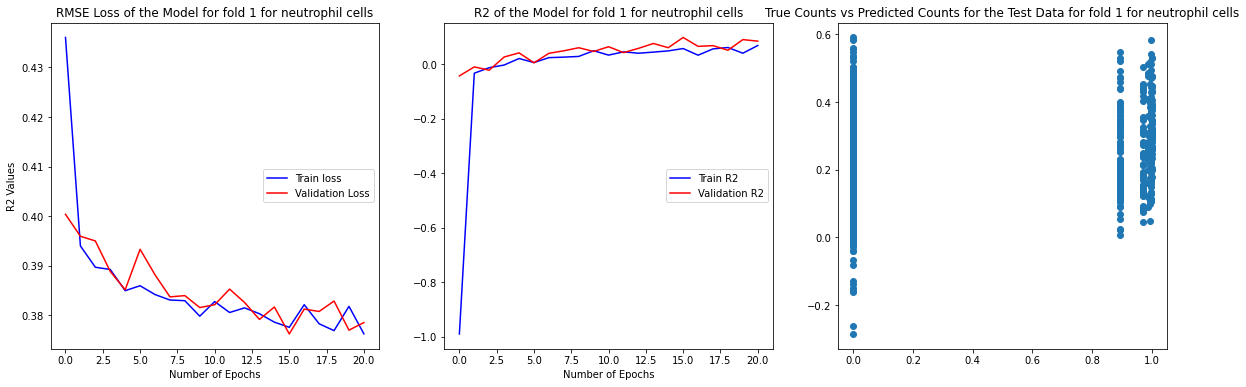

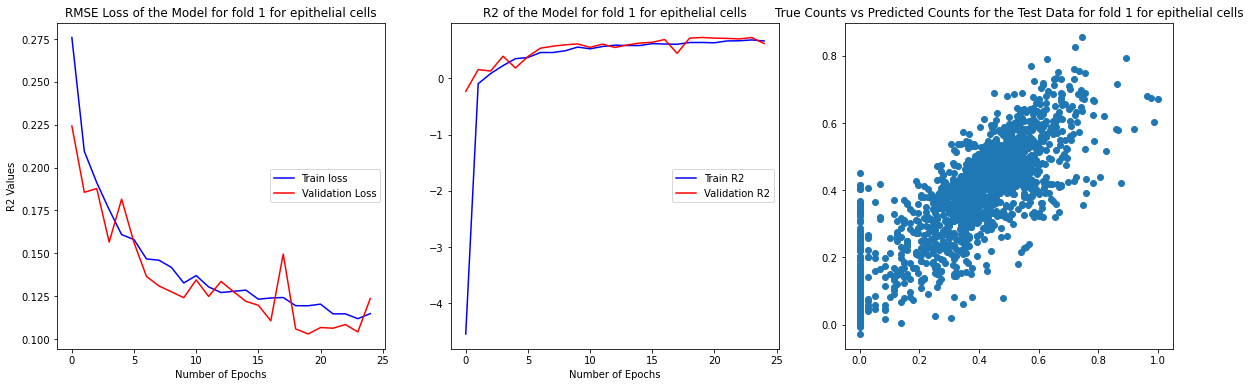

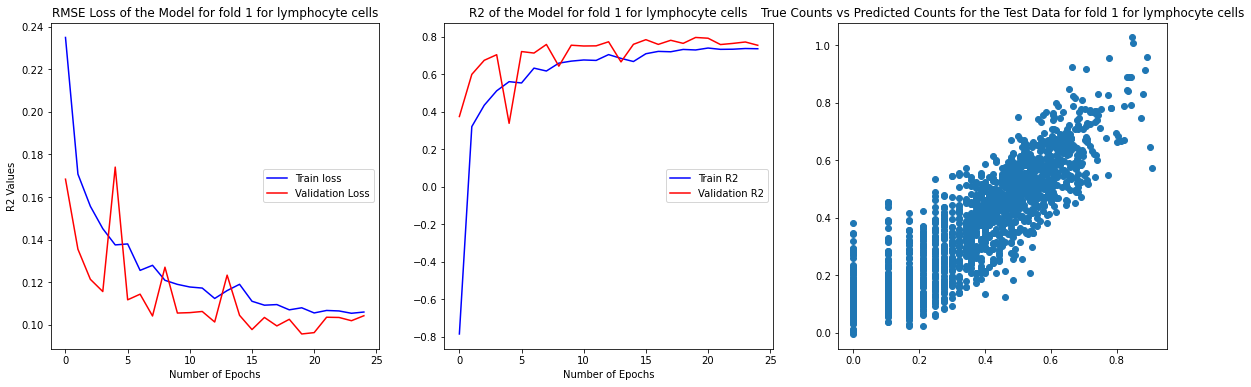

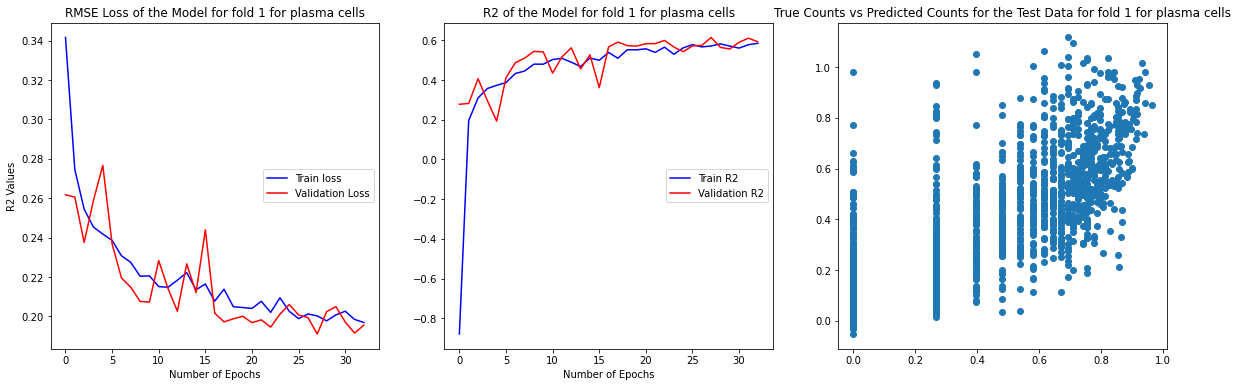

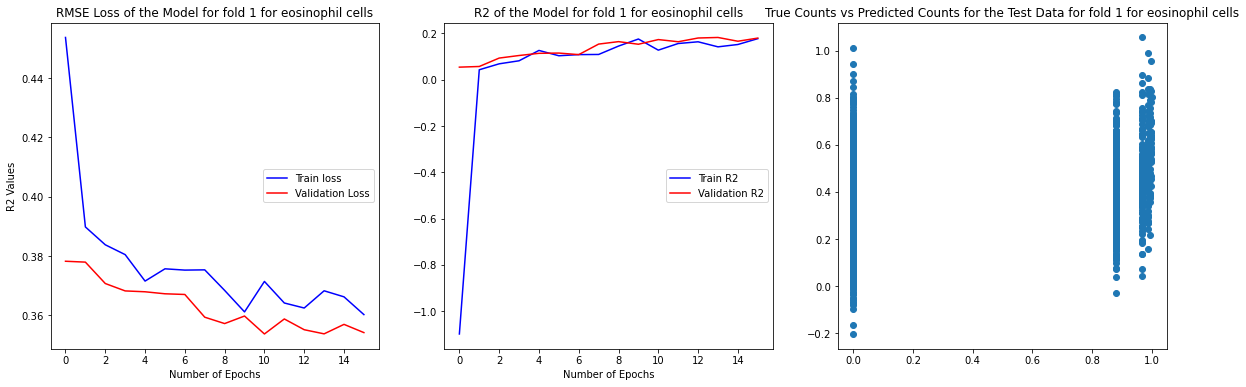

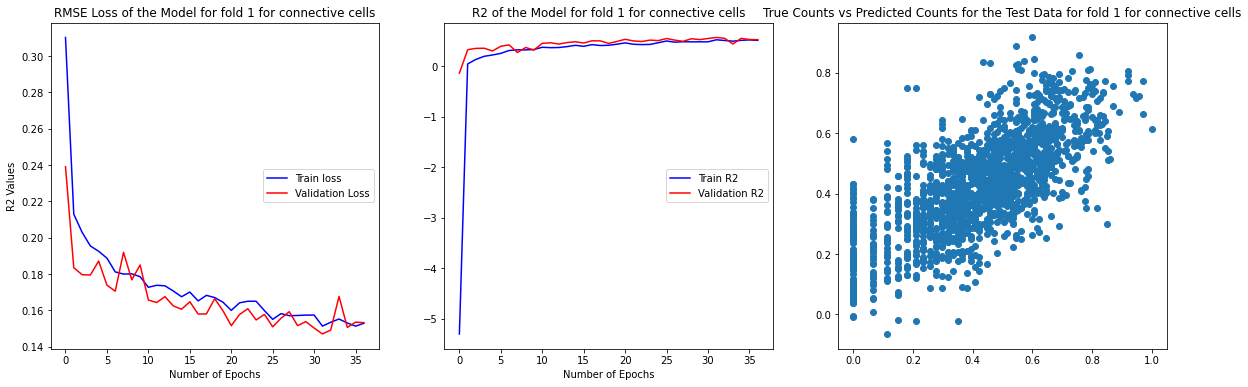

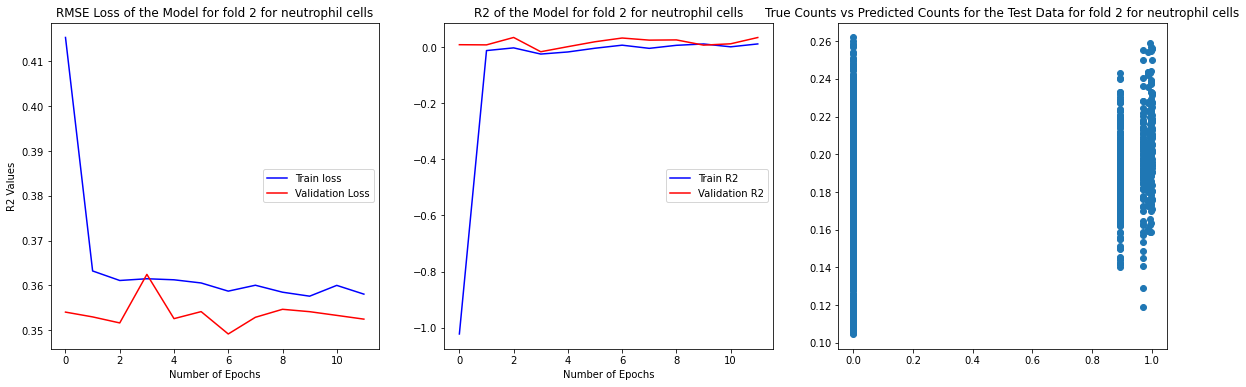

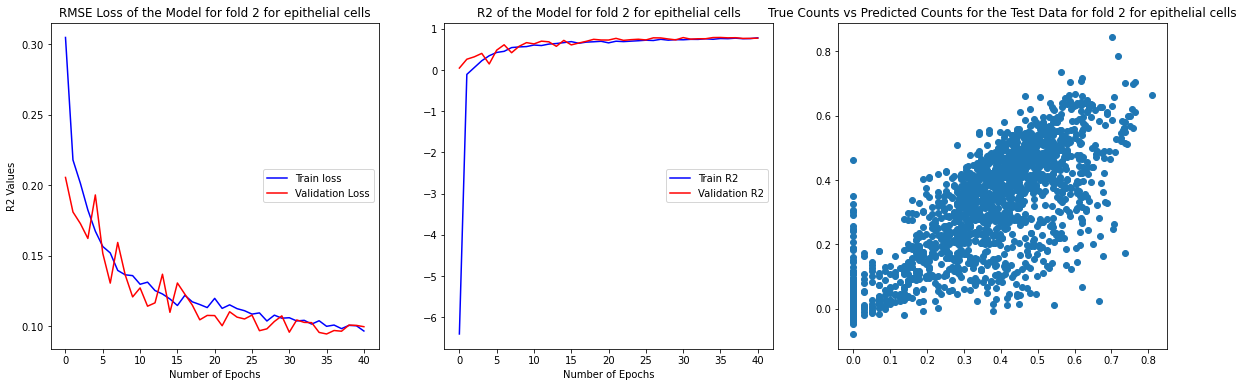

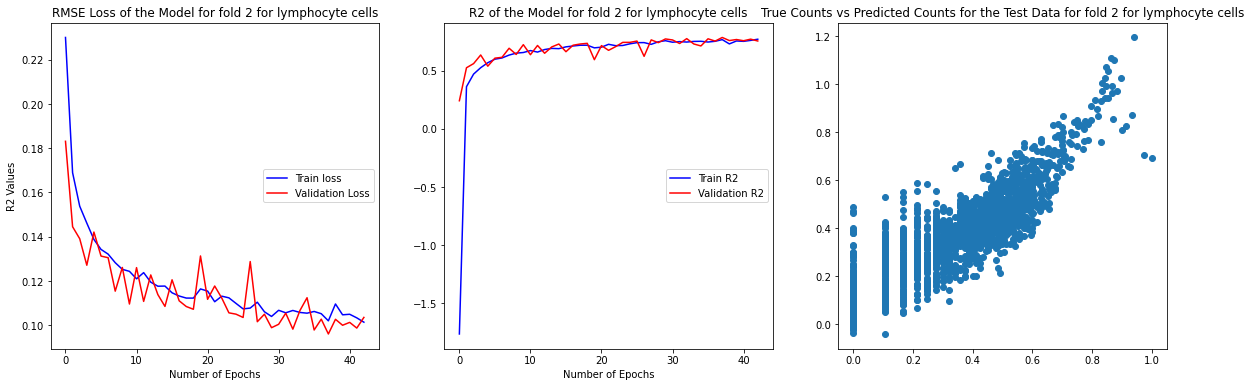

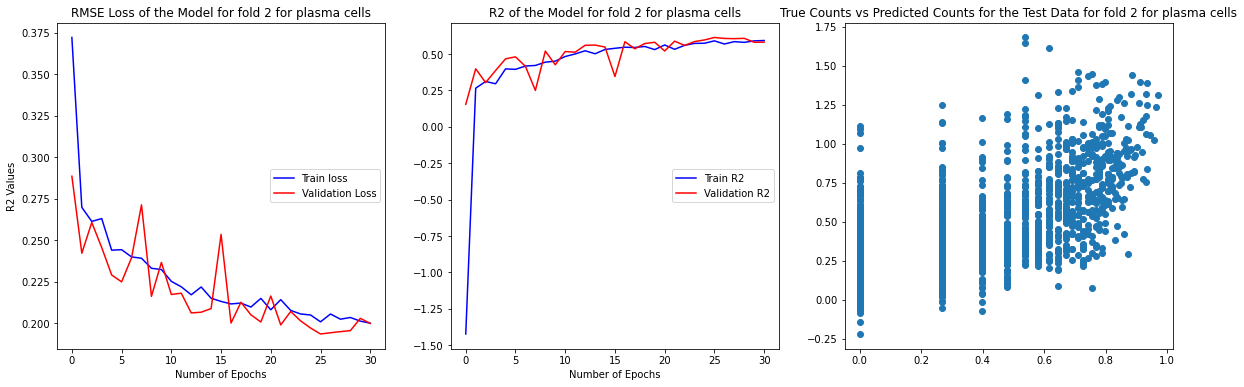

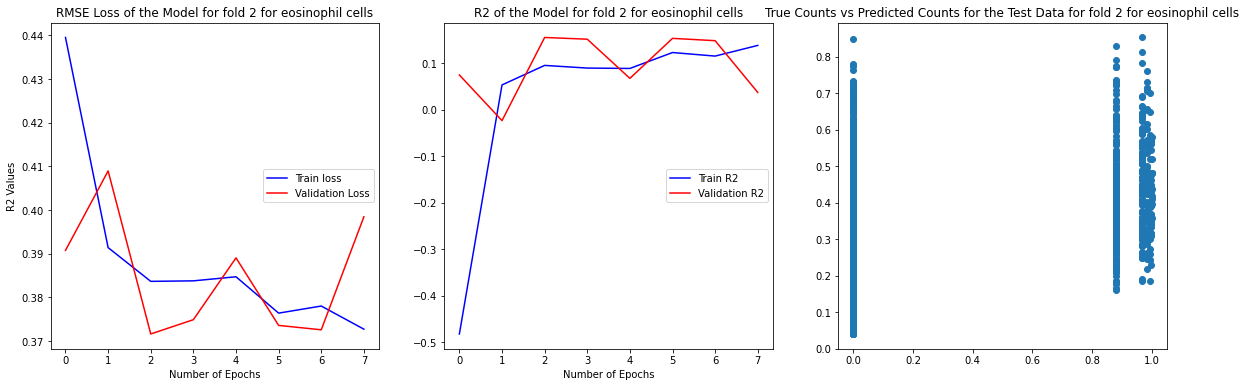

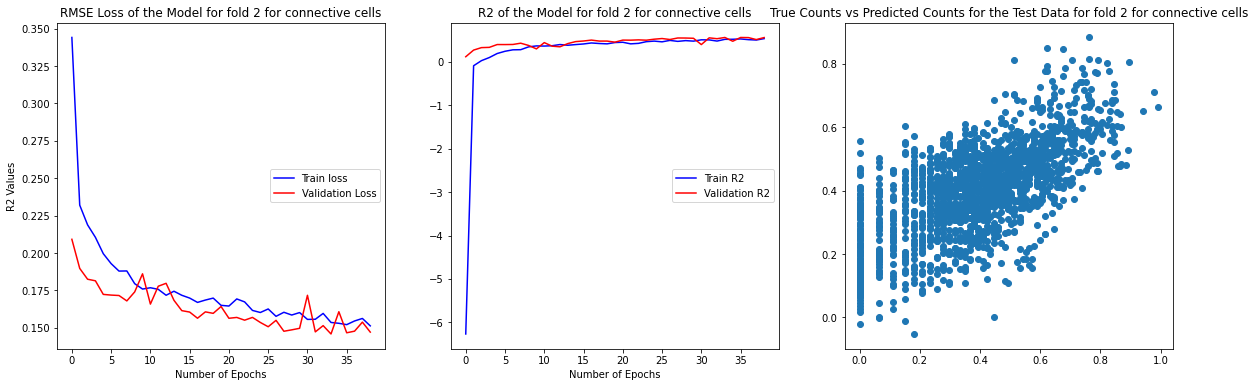

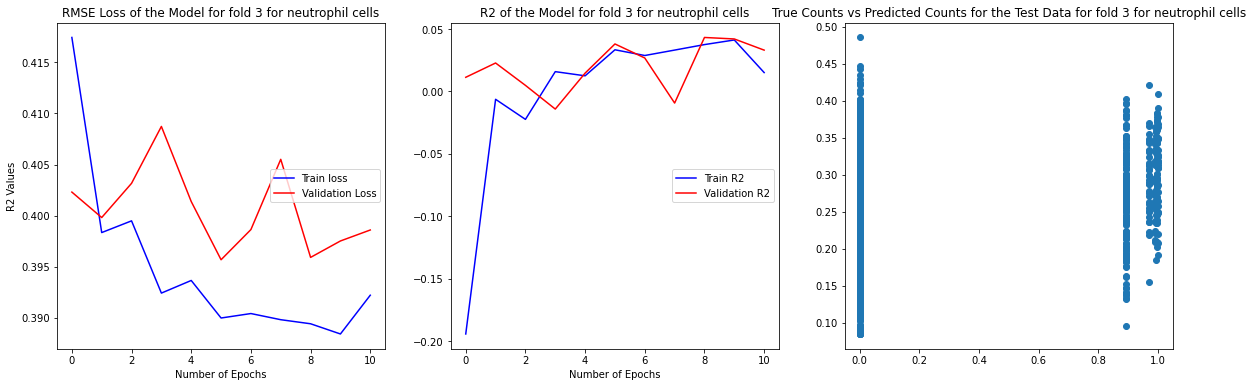

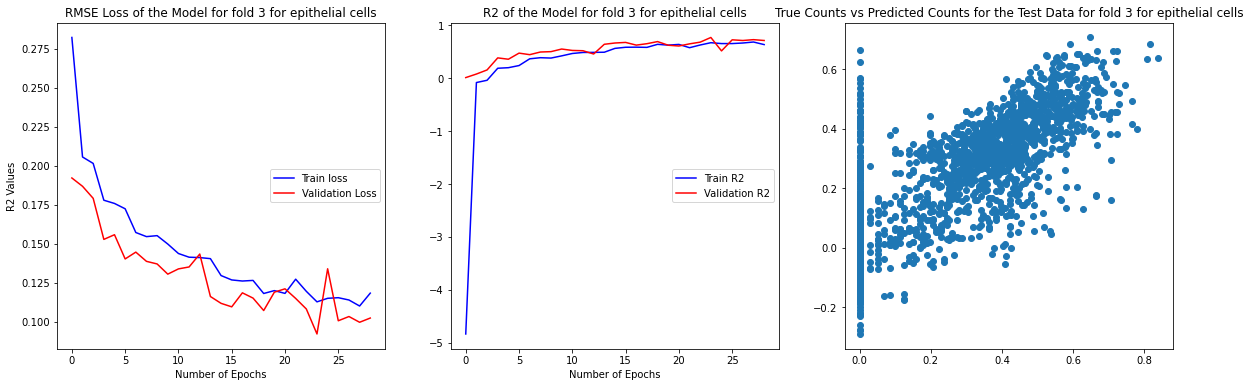

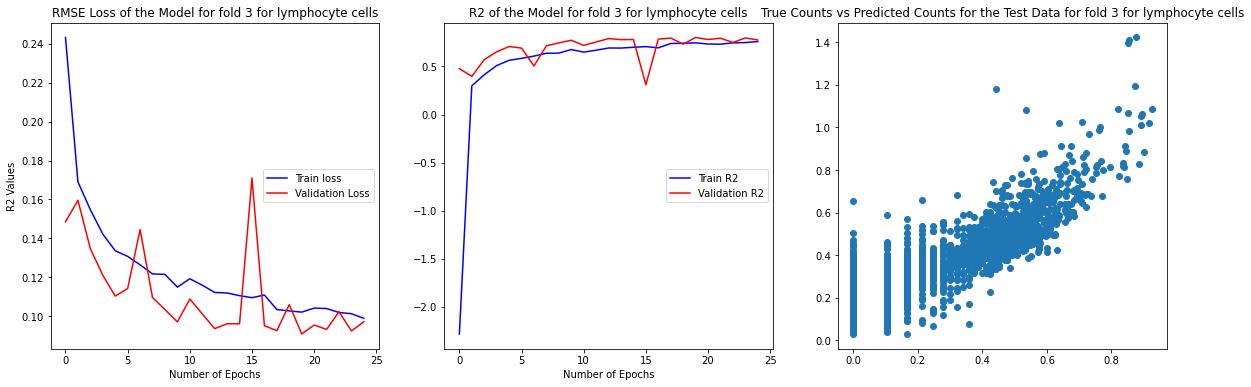

In [57]:
ALL_RESULTS = {}
for fold in range(1,4):
    print('Test data used for this fold is %d'%(fold))
    for cell_type in ['neutrophil', 'epithelial', 'lymphocyte', 'plasma', 'eosinophil','connective']:
        print("\tPrediction for the %s cell type"%(cell_type))
        cell_results = ALL_RESULTS.get(cell_type)
        if cell_results is None:
            cell_results = {'PEARSONR':[],'SPEARMAN':[],'RSQUARE':[],'RMSE':[]}
        
        target_data = Y[cell_type]
        target_data,_ = boxcox(target_data+1)
        target_data = MinMaxScaler().fit_transform(target_data.reshape(-1,1))

        test_data_x = X[np.where(F==fold,)]
        test_data_y = target_data[np.where(F==fold,)].reshape(-1)
    
        train_valid_data_x = X[np.where(F!=fold,)]
        train_valid_data_y = target_data[np.where(F!=fold,)].reshape(-1)
        
        datagen = ImageDataGenerator(rotation_range=10,
                             horizontal_flip=True, 
                             vertical_flip=True,
                            preprocessing_function=orthogonal_rot,validation_split=0.2,)
        test_datagen = ImageDataGenerator()
    
        train_data_X,validation_data_X,train_data_y,validation_data_y =  train_test_split(train_valid_data_x,train_valid_data_y,test_size=0.2)
        del train_valid_data_x,train_valid_data_y

        training_generator = datagen.flow(train_data_X,train_data_y, batch_size=BATCH)
        valid_generator = datagen.flow(x=validation_data_X, y=validation_data_y, batch_size=BATCH)
        test_generator = test_datagen.flow(x=test_data_x, y=test_data_y, batch_size=BATCH)

        model = prepare_model()
        hist = model.fit(training_generator, validation_data=valid_generator,epochs=50,verbose=0,
                         callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5,restore_best_weights=True)])

        test_predictions = model.predict(test_data_x)
            
        test_rmse = np.sqrt(mean_squared_error(test_data_y,test_predictions))
        cell_results['RMSE'].append(test_rmse)
        print("\tRMSE for the Testing data for %s cells for fold %d is"%(cell_type,fold),test_rmse)
        
        test_pearson = pearsonr(test_data_y,test_predictions.reshape(-1))[0]
        cell_results['PEARSONR'].append(test_pearson)
        print("\tPearson Correlation Coefficient for the Testing data for %s cells for fold %d is"%(cell_type,fold),test_pearson)
        
        test_spearman = spearmanr(test_data_y,test_predictions.reshape(-1))[0]
        cell_results['SPEARMAN'].append(test_spearman)
        print("\tSpearman Correlation Coefficient for the Testing data for %s cells for fold %d is"%(cell_type,fold),test_spearman)
        
        test_rsquare = r2_score(test_data_y,test_predictions.reshape(-1))
        cell_results['RSQUARE'].append(test_rsquare)
        print("\tR-Square for the Testing data for %s cells for fold %d is"%(cell_type,fold),test_rsquare)
        
        ALL_RESULTS[cell_type] = cell_results
        
        fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(20,6))
        ax1.plot(hist.epoch,hist.history['loss'],c='blue',label='Train loss')
        ax1.plot(hist.epoch,hist.history['val_loss'],c='red',label='Validation Loss')
        ax1.set_xlabel('Number of Epochs')
        ax1.set_ylabel('RMSE Loss')
        ax1.set_title('RMSE Loss of the Model for fold %d for %s cells'%(fold,cell_type))
        ax1.legend(loc="center right")

        ax2.plot(hist.epoch,hist.history['r_square'],c='blue',label='Train R2')
        ax2.plot(hist.epoch,hist.history['val_r_square'],c='red',label='Validation R2')
        ax2.set_xlabel('Number of Epochs')
        ax1.set_ylabel('R2 Values')
        ax2.set_title('R2 of the Model for fold %d for %s cells'%(fold,cell_type))
        ax2.legend(loc="center right")

        ax3.scatter(test_data_y,test_predictions)
        ax3.set_title('True Counts vs Predicted Counts for the Test Data for fold %d for %s cells'%(fold,cell_type))
        
        print('\t********* End of Prediction for %s cell type *************'%(cell_type))
        print()
    print('************** End of Predictions for Fold %d *************'%(fold))
    print()
print('*******************************************************************************')
for cell_type,result_dict_cell in ALL_RESULTS.items():
    for result_type in result_dict_cell:
        print('Mean %s score for %s cells across all folds is '%(result_type,cell_type),np.array(result_dict_cell[result_type]).mean())
    print()